In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import tqdm as tqdm
from IPython.display import clear_output
import argparse

from metrics import analysis
from mechanism import GaussOpt
from data_structure import GeoSpine, OD_tree

# Load the data

In [3]:
folder_path = "../data/Italy/"
with open(os.path.join(folder_path, "structure/geo_spine.pickle"), "rb") as f:
    geo_spine = pickle.load(f)

# upload csv data
df = pd.read_csv(os.path.join(folder_path, "data.csv"))

spine = GeoSpine(geo_spine)
Tree = OD_tree(df, spine)

## Histogram of counts for the O/D pairs

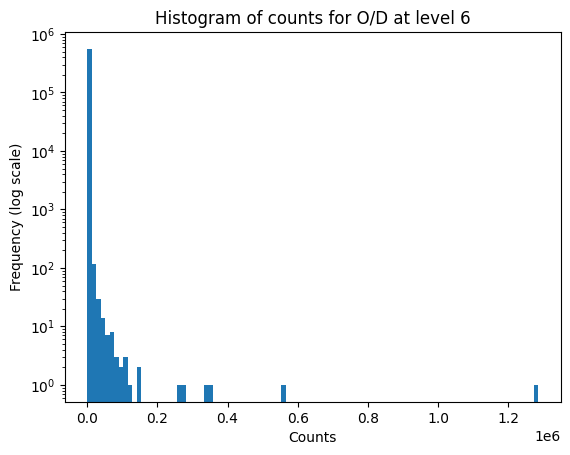

In [4]:
import matplotlib.pyplot as plt

# Assuming `Tree.data` is a pandas DataFrame
data_true = Tree.get_data_at_level(Tree.depth)

# Plot histogram
plt.hist(data_true["COUNT"], bins=100, density=False, log=True)
plt.title(f"Histogram of counts for O/D at level {Tree.depth}")
plt.xlabel("Counts")
plt.ylabel("Frequency (log scale)")
plt.show()

In [5]:
final_level = Tree.depth
geo_level = int(final_level / 2)
print("Sparsity of the data ", 1 - len(data_true) / (len(Tree.spine.get_nodes(level=geo_level)) ** 2))

Sparsity of the data  0.9915070852277406


# Apply mechansims

In [6]:
epsilons = [10.]
delta = 1E-8
num_experiments = 1
# used to queries
levels: list[tuple] = [(i, i) if i == j else (i, j) for i in range(geo_level + 1) for j in range(i, i + 2) if
                       j < geo_level + 1]
# mechanisms, epsilons, experiments, levels
num_mechanisms = 4
max_error_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_discovery_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
false_negative_rate_sparse = np.zeros((num_mechanisms, 2, num_experiments, len(levels)))
MAE = np.zeros((num_mechanisms, 2, len(levels)))
std = np.zeros((num_mechanisms, 2, len(levels)))

In [7]:
def apply_mechanism(mech: callable, args: argparse.Namespace, num_mech: int, num_eps: int):
    absolute_error_distribution_epsilon = []
    for i in range(num_experiments):
        print(f"Experiment {i + 1}")
        data = mech(Tree, args)
        absolute_error_distribution = []
        for j, level in enumerate(tqdm.tqdm(levels, colour="green")):
            workload = [[f"LEVEL{level[0]}_ORIG", f"LEVEL{level[1]}_DEST"]]
            analysis_dict = analysis(data_true=data_true,
                                     dp_data=data,
                                     spine=Tree.spine,
                                     workload=workload)
            max_error_sparse[num_mech, e, i, j] = analysis_dict["max_absolute_error"]
            false_discovery_rate_sparse[num_mech, e, i, j] = analysis_dict["false_discovery_rate"]
            false_negative_rate_sparse[num_mech, e, i, j] = analysis_dict["false_negative_rate"]
            absolute_error_distribution.append(np.abs(analysis_dict["error_distribution"][0]))
        absolute_error_distribution_epsilon.append(absolute_error_distribution)
        # clear jupyter output on the terminal
        clear_output(wait=True)
    # absolute_error_distribution_epsilon is a list of lists that needs to be concatenated
    error_to_add = np.zeros(len(levels))
    std_to_add = np.zeros(len(levels))
    for j in range(len(levels)):
        concantenation = []
        # concatenate the list of lists
        for i in range(num_experiments):
            concantenation.append(absolute_error_distribution_epsilon[i][j])
        # assert they are all the same length
        assert len(set([len(x) for x in concantenation])) == 1
        # flatten the list
        error_to_add[j] = np.mean(np.concatenate(concantenation))
        std_to_add[j] = np.std(np.concatenate(concantenation))
    MAE[num_mech, num_eps] = error_to_add
    std[num_mech, num_eps] = std_to_add

## Apply GaussOpt $L_1$ norm

In [97]:
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, p=1, optimizer="int",
                          split_method='uniform', show_tqdm=True)

num_mech = 0
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(GaussOpt, args, num_mech, e)

Experiment 1
Optimizing level 1/6...


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Optimizing level 2/6...


100%|██████████| 20/20 [00:00<00:00, 24.86it/s]


Optimizing level 3/6...


100%|██████████| 286/286 [00:08<00:00, 32.87it/s]


Optimizing level 4/6...


100%|██████████| 1044/1044 [00:31<00:00, 33.40it/s]


Optimizing level 5/6...


100%|██████████| 4304/4304 [02:55<00:00, 24.53it/s]


Optimizing level 6/6...


100%|██████████| 63644/63644 [39:54<00:00, 26.57it/s]


Time taken to create the dataset: 2614.37 seconds
Done!


100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


## Apply GaussOpt $L_2$ norm

In [96]:
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, p=2, optimizer="int",
                          split_method='uniform', show_tqdm=True)

num_mech = 1
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(GaussOpt, args, num_mech, e)

Experiment 1
Optimizing level 1/6...


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Optimizing level 2/6...


100%|██████████| 20/20 [00:00<00:00, 23.94it/s]


Optimizing level 3/6...


100%|██████████| 285/285 [00:08<00:00, 32.32it/s]


Optimizing level 4/6...


100%|██████████| 1057/1057 [00:32<00:00, 32.93it/s]


Optimizing level 5/6...


100%|██████████| 4285/4285 [03:00<00:00, 23.77it/s]


Optimizing level 6/6...


100%|██████████| 54934/54934 [35:03<00:00, 26.12it/s] 


Time taken to create the dataset: 2328.70 seconds
Done!


100%|██████████| 7/7 [00:18<00:00,  2.60s/it]


## Apply GaussOpt $L_\infty$ norm

In [25]:
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, p="inf", optimizer="int",
                          split_method='uniform', show_tqdm=False)

num_mech = 2
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(GaussOpt, args, num_mech, e)

Experiment 1
Optimizing level 1/6...
Optimizing level 2/6...
Optimizing level 3/6...


KeyboardInterrupt: 

## Apply GaussOpt $L_\infty$ norm with IntOpt

In [9]:
args = argparse.Namespace(delta=delta, final_level=final_level, max_contribution=1, optimizer="fast_int_opt",
                          split_method='uniform', show_tqdm=True)

num_mech = 3
for e, epsilon in enumerate(epsilons):
    args.epsilon = epsilon
    apply_mechanism(GaussOpt, args, num_mech, e)

Experiment 1
Optimizing level 1/6...


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Optimizing level 2/6...


100%|██████████| 20/20 [00:00<00:00, 23.77it/s]


Optimizing level 3/6...


 77%|███████▋  | 183/238 [00:05<00:01, 32.98it/s]


KeyboardInterrupt: 

## Maximum Absolute Error per Level

In [10]:
mechanisms = ["GaussOpt_p1", "GaussOpt_p2", "GaussOpt_pinf", "GaussOpt_pinf_IntOpt"]
markers = [["-s", "-*", "-v", "-8", "-P"], ["--s", "--*", "--v", "--8", "--P"]]
colors = ["blue", "orange", "red", "green"]

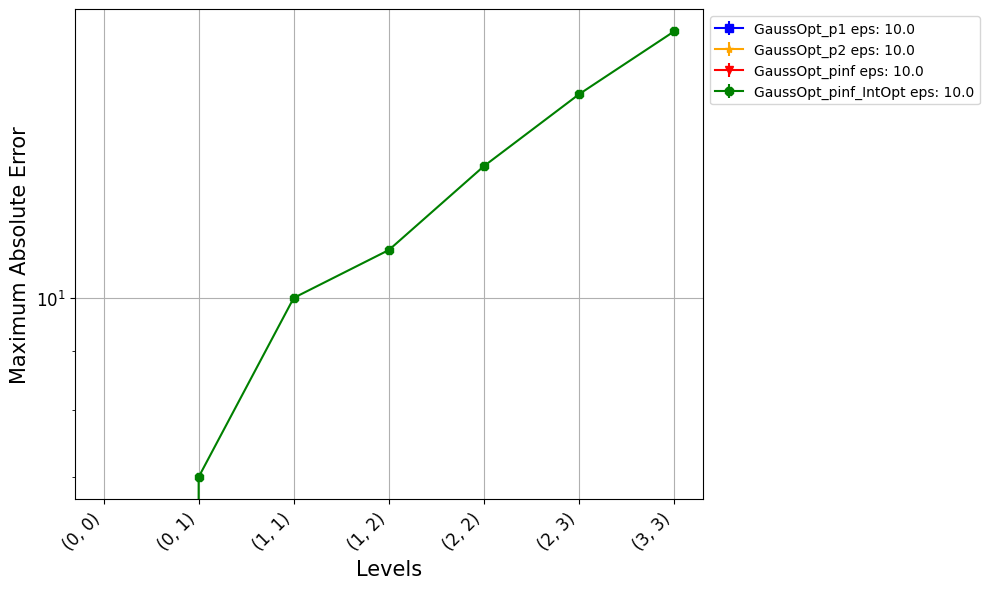

In [11]:
# plot line
import matplotlib.pyplot as plt

array = max_error_sparse
fig, ax = plt.subplots(figsize=(10, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])
ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Maximum Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../plots/Italy/max_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# put the legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# save
plt.tight_layout()
# plt.savefig(f"../plots/Italy/max_error.pdf", dpi=300)
plt.show()

## Mean Absolute Error per Level

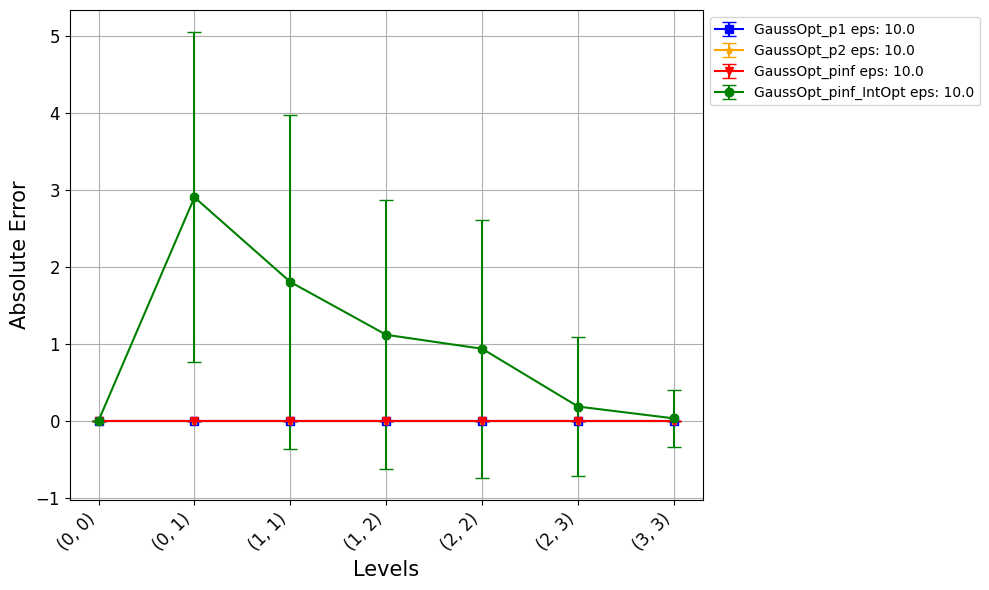

In [12]:
# plot line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        ax.errorbar(range(len(levels)), MAE[i, j], yerr=std[i, j],
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i], capsize=5)
# ax.set_yscale("log")
# Setting labels and ticks
ax.set_ylabel("Absolute Error", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../plots/Italy/mean_absolute_error_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# put the legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# save
plt.tight_layout()
# plt.savefig(f"../plots/Italy/mean_absolute_error.pdf", dpi=300)
plt.show()

## False Discovery Rate

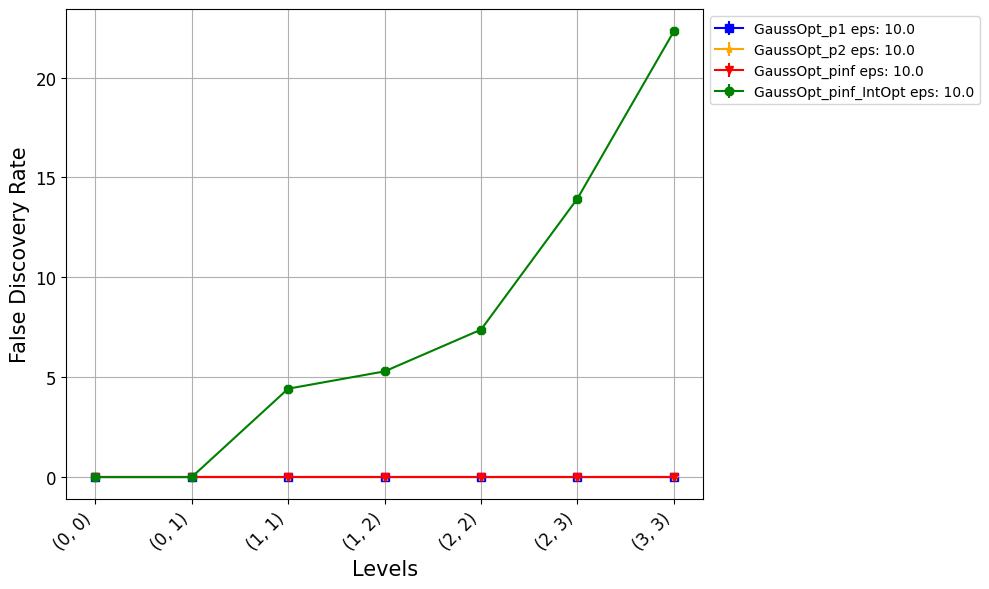

In [13]:
# plot line
import matplotlib.pyplot as plt

array = false_discovery_rate_sparse
fig, ax = plt.subplots(figsize=(10, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        error = np.abs(error)
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Discovery Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"../plots/Italy/false_discovery_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# put the legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# save
plt.tight_layout()
# plt.savefig(f"../plots/Italy/false_discovery_rate.pdf", dpi=300)
plt.show()

## False Negative Rate

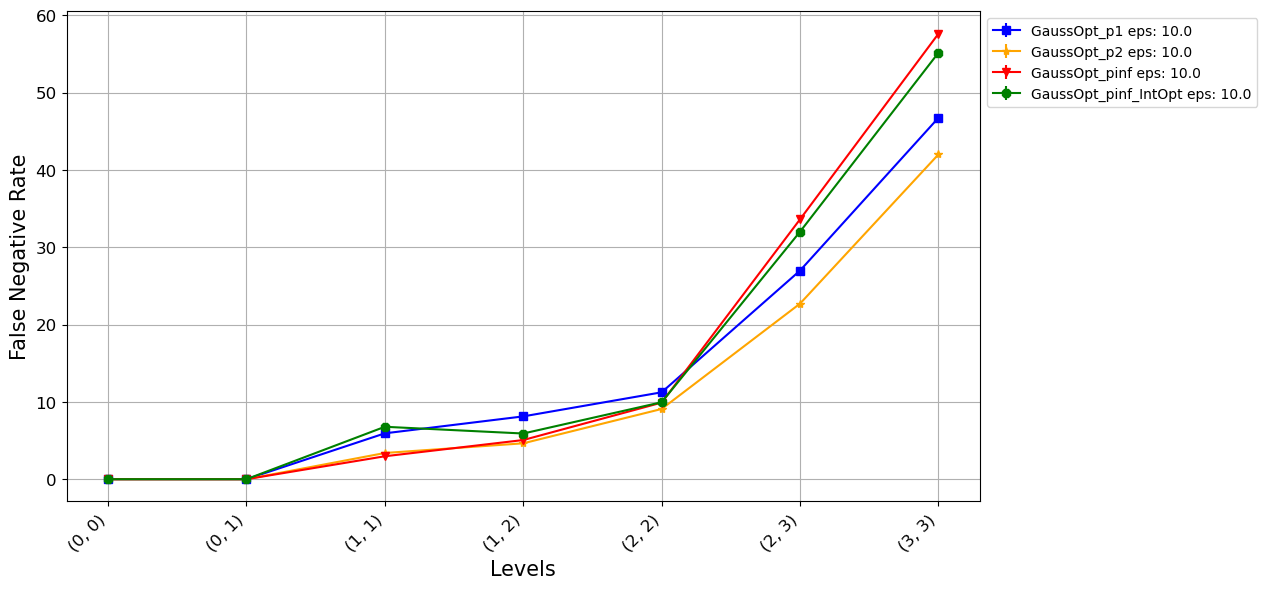

In [103]:
# plot line
import matplotlib.pyplot as plt

array = false_negative_rate_sparse
fig, ax = plt.subplots(figsize=(10, 6))
for i, mechanism in enumerate(mechanisms):
    for j, epsilon in enumerate(epsilons):
        # plot error bar line for each level using min max
        error = np.array([np.mean(array[i, j], axis=0) - np.min(array[i, j], axis=0),
                          np.max(array[i, j], axis=0) - np.mean(array[i, j], axis=0)])
        ax.errorbar(range(len(levels)), np.mean(array[i, j], axis=0), yerr=error,
                    label=mechanism + f" eps: {epsilon}",
                    fmt=markers[j][i], color=colors[i])

# Setting labels and ticks
ax.set_ylabel("False Negative Rate", fontsize=15)
ax.set_xlabel("Levels", fontsize=15)  # Optional: Add an x-label for clarity
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=45, ha='right')  # Set oblique labels
# augment font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display the plot
plt.grid(True)
# save
plt.tight_layout()
# plt.savefig(f"../plots/Italy/false_negative_rate_nolegend.pdf", dpi=300)
# Adding a legend
plt.legend()
# put the legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.savefig(f"../plots/Italy/false_negative_rate.pdf", dpi=300)
plt.show()